# **Evaluating Privacy Loss During the Federated Learning Process**

Federated Learning can leak private information through sharing the models. This side-effect is known as the *deep leakage from gradients*.

In [1]:
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FL_PRIV_NUM_MEAS = 5
TRAINING_DAYS = 4
SHARING_METHODS = ["ref", "all_data", "alters", "zopt"]
SHARING_METHODS_NAMES = ["reference", "all data", "alters", "zopt"]

In [3]:
FL_PRIV_ROOT = "../../02_data/05_fl_privacy/broad/"

In [4]:
sharing_methods, vehicles, veh_types, positions, time_offsets, meases = [], [], [], [], [], []

for sm in SHARING_METHODS:
    for mc in range(FL_PRIV_NUM_MEAS):
        try:
            with open(f"{FL_PRIV_ROOT}/{mc}/{sm}/inference_results.json") as f:
                eval_results = json.load(f)
                for veh in eval_results:
                    if len(eval_results[veh]) != 0:
                        sharing_methods.append(sm)
                        vehicles.append(veh)
                        positions.append(len(eval_results[veh]["positions"]))
                        time_offsets.append(eval_results[veh]["time_offset"])
                        
                        if veh.startswith("h"):
                            veh_type = "household"
                        elif veh.startswith("c"):
                            veh_type = "commute"
                        elif veh.startswith("r"):
                            veh_type = "random"
                        veh_types.append(veh_type)
                        meases.append(mc)
        except:
            pass
                    
                    
                
infer_perf = pd.DataFrame()
infer_perf["sharing_method"] = sharing_methods
infer_perf["vehicle"] = vehicles
infer_perf["vehicle_type"] = veh_types
infer_perf["position"] = positions
infer_perf["time_offset"] = time_offsets
infer_perf["time_offset"] = np.abs(infer_perf["time_offset"])
infer_perf["meas"] = meases

## Overview

Text(0.5, 1.0, 'Position inference success rate\nduring training')

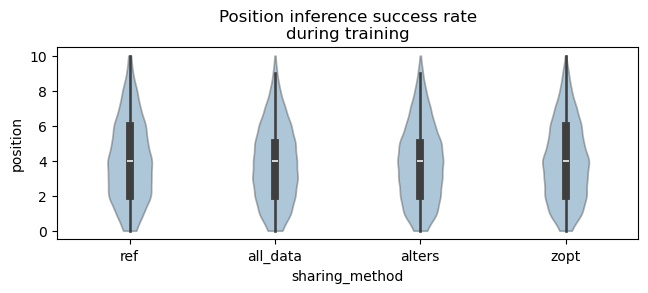

In [5]:
fig, ax = plt.subplots(1, figsize=(7.5, 2.5))
'''sns.boxplot(ax=ax, data=infer_perf, x="sharing_method", y="position",
            width=0.4, gap=0.2, whis=[5, 95], legend=True,
            fliersize=3.0, flierprops={"alpha": 0.2},
            medianprops={"linewidth":3})'''
sns.violinplot(ax=ax, data=infer_perf, x="sharing_method", y="position",
            width=0.4, gap=0.2, cut=False, legend=True, alpha=0.4)

plt.title("Position inference success rate\nduring training")
#sns.move_legend(ax, loc="lower center", bbox_to_anchor=(0.5, -0.45), ncol=4)

**Analysis**

Overall, there are no significant differences between the sharing methods from a statistical point of view. However, for individual cars, the differences can be fundamental.

## For individual cars

In [6]:
veh_ids, position_diff, time_diff, sharing_method, veh_types = [], [], [], [], []
for veh in infer_perf["vehicle"].unique():
    veh_data = infer_perf[infer_perf["vehicle"] == veh]
    for meas in range(FL_PRIV_NUM_MEAS):
        meas_veh_data = veh_data[veh_data["meas"] == meas]
        if len(meas_veh_data[meas_veh_data["sharing_method"] == "ref"])>0:
            ref_mean_pos = meas_veh_data[meas_veh_data["sharing_method"] == "ref"]["position"].iloc[0]
            ref_mean_time = meas_veh_data[meas_veh_data["sharing_method"] == "ref"]["time_offset"].iloc[0]
            for sm in SHARING_METHODS:
                if veh.startswith("c"):
                    veh_type = "commute"
                elif veh.startswith("h"):
                    veh_type = "household"
                else:
                    veh_type = "random"
                if sm != "ref":
                    if len(meas_veh_data[meas_veh_data["sharing_method"] == sm])>0:
                        pos = meas_veh_data[meas_veh_data["sharing_method"] == sm]["position"].iloc[0]
                        time = meas_veh_data[meas_veh_data["sharing_method"] == sm]["time_offset"].iloc[0]
                        veh_ids.append(veh)
                        position_diff.append(ref_mean_pos-pos)
                        time_diff.append(time-ref_mean_time)
                        sharing_method.append(SHARING_METHODS_NAMES[SHARING_METHODS.index(sm)])
                        veh_types.append(veh_type)
            
per_vehicle_df = pd.DataFrame()
per_vehicle_df["veh_ids"] = veh_ids
per_vehicle_df["position_diff"] = position_diff
per_vehicle_df["time_diff"] = time_diff
per_vehicle_df["sharing_method"] = sharing_method
per_vehicle_df["veh_types"] = veh_types

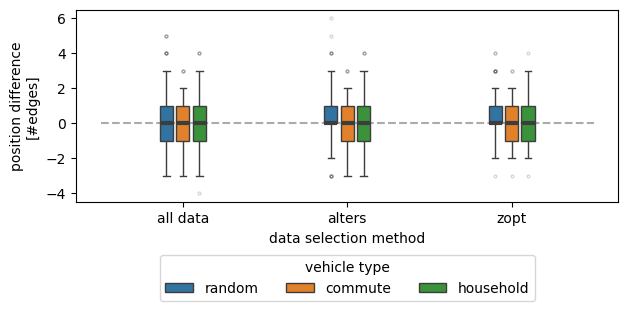

In [15]:
plt.figure(figsize=(7, 2.5))
sns.boxplot(data=per_vehicle_df, x="sharing_method", y="position_diff", hue="veh_types",
            width=0.3, gap=0.2, whis=[1, 99], legend=True, fliersize=2.0, flierprops={"alpha": 0.2},
                medianprops={"linewidth":3})
plt.xlabel("data selection method")
plt.ylabel("position difference\n[#edges]")

plt.hlines(y=0, xmin=-0.5, xmax=2.5, zorder=0, linestyle="--", color="k", alpha=0.33,)
plt.legend(title="vehicle type", ncols=3, loc="lower center", bbox_to_anchor=(.5, -.55))

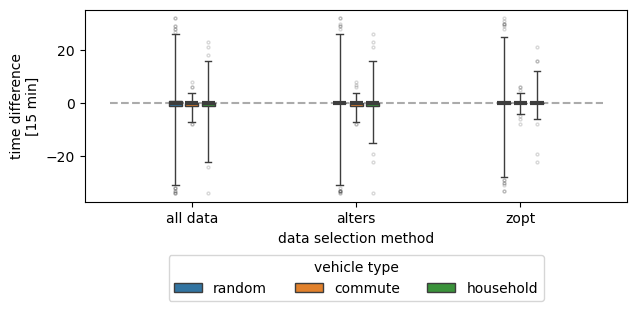

In [13]:
plt.figure(figsize=(7, 2.5))
sns.boxplot(data=per_vehicle_df, x="sharing_method", y="time_diff", hue="veh_types",
            width=0.3, gap=0.2, whis=[1, 99], legend=True, fliersize=2.0, flierprops={"alpha": 0.2},
                medianprops={"linewidth":3})
plt.xlabel("data selection method")
plt.ylabel("time difference\n[15 min]")

plt.hlines(y=0, xmin=-0.5, xmax=2.5, zorder=0, linestyle="--", color="k", alpha=0.33,)
plt.legend(title="vehicle type", ncols=4, loc="lower center", bbox_to_anchor=(.5, -.55))

In [9]:
per_vehicle_df.to_csv(f"{FL_PRIV_ROOT}/fl_sec_per_vehicle.csv", index=False)

### Check differences

In [5]:
FL_PRIV_ROOT_ROOT = "../../02_data/05_fl_privacy/"

In [6]:
narrow = pd.read_csv(f"{FL_PRIV_ROOT_ROOT}/narrow/fl_sec_per_vehicle.csv")
narrow = narrow.set_index(["veh_ids", "sharing_method"])
narrow = narrow.drop(columns=["veh_types"])

broad = pd.read_csv(f"{FL_PRIV_ROOT_ROOT}/broad/fl_sec_per_vehicle.csv")
broad = broad.set_index(["veh_ids", "sharing_method"])
broad = broad.drop(columns=["veh_types"])

In [7]:
diff_df = (narrow - broad)
diff_df = diff_df.dropna()

veh_types = []
for i,r in diff_df.iterrows():
    if i[0].startswith("c"):
        veh_types.append("commute")
    elif i[0].startswith("h"):
        veh_types.append("household")
    else:
        veh_types.append("random")
        
diff_df["veh_type"] = veh_types

In [38]:
diff_df

position_diff  time_diff veh_type
veh_ids    sharing_method                                   
carIn11    all data                 -3.0        2.0  commute
           all data                 -2.0        0.0  commute
           all data                 -2.0        2.0  commute
           all data                 -1.0        0.0  commute
           alters                   -2.0        4.0  commute
...                                  ...        ...      ...
randUni9:5 all data                 -2.0        0.0   random
           alters                    0.0       28.0   random
           alters                   -1.0       27.0   random
           zopt                     -1.0       28.0   random
           zopt                      0.0       27.0   random

[2554 rows x 3 columns]

In [8]:
long_diff = pd.DataFrame()

sharing_methods = []
veh_types = []
value = []
value_type = []
for i,r in diff_df.iterrows():
    sharing_methods.append(i[1])
    sharing_methods.append(i[1])
    veh_types.append(r.veh_type)
    veh_types.append(r.veh_type)
    value.append(r.position_diff)
    value_type.append("position difference")
    value.append(r.time_diff)
    value_type.append("time difference")
    
long_diff["sharing method"] = sharing_methods
long_diff["vehicle type"] = veh_types
long_diff["value"] = value
long_diff["value_type"] = value_type

In [10]:
long_diff

,sharing method,vehicle type,value,value_type
0,all data,commute,-3.0,position difference
1,all data,commute,2.0,time difference
2,all data,commute,-2.0,position difference
3,all data,commute,0.0,time difference
4,all data,commute,-2.0,position difference
...,...,...,...,...
5103,alters,random,27.0,time difference
5104,zopt,random,-1.0,position difference
5105,zopt,random,28.0,time difference
5106,zopt,random,0.0,position difference


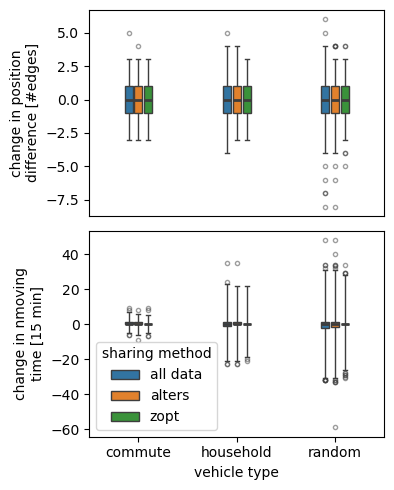

In [45]:
fig, ax = plt.subplots(2,1, figsize=(4,5))
sns.boxplot(data=long_diff[long_diff["value_type"] == "position difference"],
            x="vehicle type", y="value", hue="sharing method", ax=ax[0],
            width=0.3, gap=0.2, whis=[1,99], fliersize=3.0,
            flierprops={"alpha": 0.5},
            medianprops={"linewidth":2}, legend=False)
ax[0].set_ylabel("change in position\ndifference [#edges]")
ax[0].set_xlabel("")
ax[0].set_xticks([])
sns.boxplot(data=long_diff[long_diff["value_type"] == "time difference"],
            x="vehicle type", y="value", hue="sharing method", ax=ax[1],
            width=0.3, gap=0.2, whis=[1,99], fliersize=3.0,
            flierprops={"alpha": 0.5},
            medianprops={"linewidth":2})
ax[1].set_ylabel("change in nmoving\ntime [15 min]")
fig.tight_layout()